In [66]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [67]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

In [68]:
device='cpu'

## Define target density

In [69]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [70]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [71]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

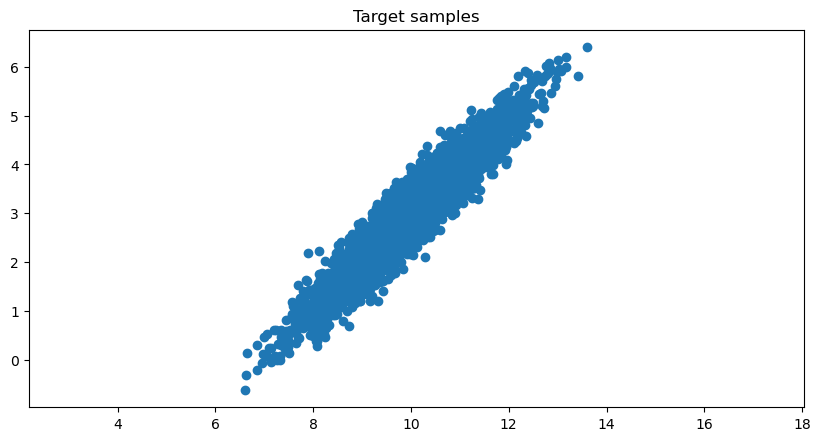

In [72]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [73]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [74]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [75]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▍                                                                           | 183/10000 [00:00<00:10, 919.13it/s]

Current value of KL at batch number 0 is 273.72308349609375


 11%|████████▎                                                                  | 1102/10000 [00:01<00:07, 1170.51it/s]

Current value of KL at batch number 1000 is 18.41696548461914


 22%|████████████████▏                                                          | 2161/10000 [00:02<00:07, 1104.04it/s]

Current value of KL at batch number 2000 is 9.9132719039917


 32%|████████████████████████                                                   | 3214/10000 [00:02<00:05, 1145.94it/s]

Current value of KL at batch number 3000 is 3.699676513671875


 42%|███████████████████████████████▎                                           | 4169/10000 [00:03<00:05, 1154.96it/s]

Current value of KL at batch number 4000 is 1.565246820449829


 52%|██████████████████████████████████████▉                                    | 5199/10000 [00:04<00:04, 1051.61it/s]

Current value of KL at batch number 5000 is 1.1421687602996826


 61%|█████████████████████████████████████████████▉                             | 6122/10000 [00:05<00:03, 1100.04it/s]

Current value of KL at batch number 6000 is 1.1212313175201416


 72%|█████████████████████████████████████████████████████▊                     | 7174/10000 [00:06<00:02, 1079.93it/s]

Current value of KL at batch number 7000 is 1.1344777345657349


 81%|████████████████████████████████████████████████████████████▉              | 8119/10000 [00:07<00:01, 1109.25it/s]

Current value of KL at batch number 8000 is 1.1111677885055542


 92%|████████████████████████████████████████████████████████████████████▊      | 9179/10000 [00:08<00:00, 1079.44it/s]

Current value of KL at batch number 9000 is 1.1634759902954102


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1099.59it/s]


### Plot both: samples from variational family and target

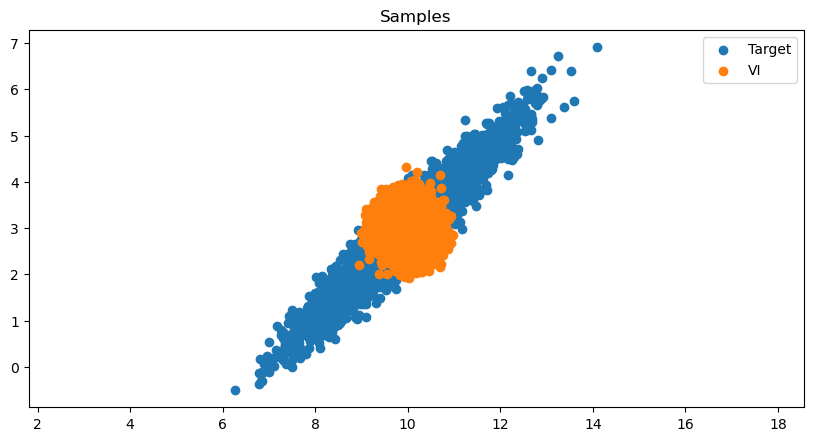

In [76]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## VI with GMM target

### Target

In [77]:
#### TODO: Добавь VI, таргетом для которого будет смесь двух гауссиан

class GMM():
    '''
    This class defines GMM (Gaussian Mixture Model) target (2d)
    '''
    def __init__(self, mus, covars):
        self.mus = mus
        self.covars = covars
        self.distr = torch.distributions.MixtureSameFamily(mus, covars)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, ))

In [332]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)

In [333]:
target_gmm = GMM(mix, comp)

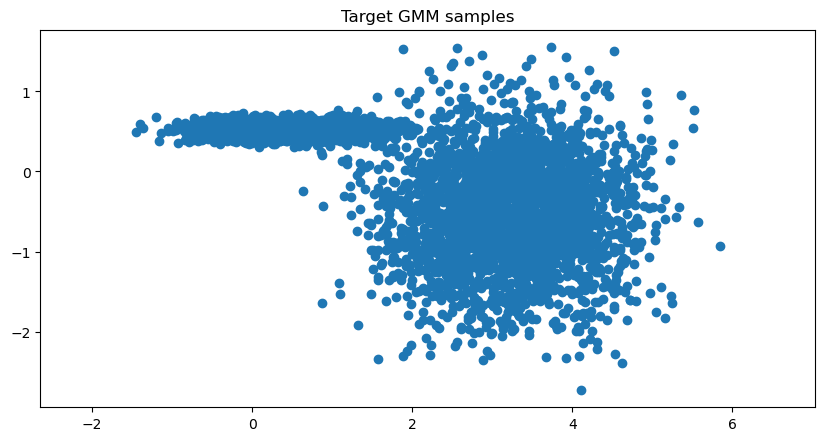

In [334]:
samples = target_gmm.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target GMM samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

### VI model: unimodal Gaussian

In [335]:
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [336]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(std_param_raw)
    z = mu_param + u * std
    
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▎                                                                           | 177/10000 [00:00<00:11, 888.13it/s]

Current value of KL at batch number 0 is 7.831753253936768


 11%|████████▌                                                                   | 1126/10000 [00:01<00:09, 944.68it/s]

Current value of KL at batch number 1000 is 0.6850154995918274


 22%|████████████████▌                                                           | 2175/10000 [00:02<00:08, 947.70it/s]

Current value of KL at batch number 2000 is 0.6860432624816895


 31%|███████████████████████▊                                                    | 3135/10000 [00:03<00:07, 952.68it/s]

Current value of KL at batch number 3000 is 0.6852022409439087


 42%|███████████████████████████████▋                                            | 4166/10000 [00:04<00:06, 910.10it/s]

Current value of KL at batch number 4000 is 0.6872848272323608


 51%|██████████████████████████████████████▊                                     | 5106/10000 [00:05<00:05, 937.42it/s]

Current value of KL at batch number 5000 is 0.6866658329963684


 61%|██████████████████████████████████████████████▋                             | 6148/10000 [00:06<00:04, 931.97it/s]

Current value of KL at batch number 6000 is 0.6842955350875854


 71%|█████████████████████████████████████████████████████▉                      | 7089/10000 [00:07<00:03, 930.09it/s]

Current value of KL at batch number 7000 is 0.6870361566543579


 81%|█████████████████████████████████████████████████████████████▊              | 8136/10000 [00:08<00:01, 947.62it/s]

Current value of KL at batch number 8000 is 0.6834335327148438


 91%|█████████████████████████████████████████████████████████████████████       | 9093/10000 [00:09<00:00, 952.23it/s]

Current value of KL at batch number 9000 is 0.6794788241386414


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 935.74it/s]


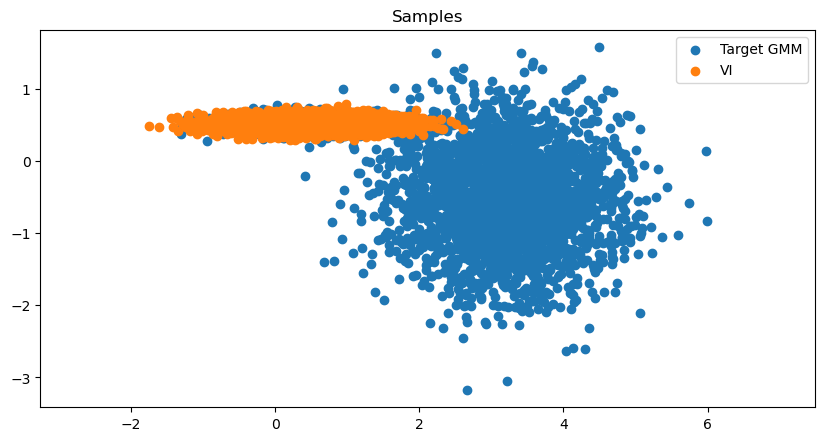

In [337]:
N = 5000

u = std_normal.sample((N, 2))
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## Approximating a mixture of Gaussians

In [375]:
mus_param = nn.Parameter(torch.tensor([[0., 0.],[1., 1.]], device=device, dtype=torch.float32))

stds_param_raw = nn.Parameter(torch.tensor([[0., 0.],[0., 0.]], device=device, dtype=torch.float32))

pi_raw = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32))

optimizer = torch.optim.Adam(params=[mus_param, stds_param_raw, pi_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


std_normal = torch.distributions.Normal(loc=mus_param[0],
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
std_normal1 = torch.distributions.Normal(loc=mus_param[0],
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
std_normal2 = torch.distributions.Normal(loc=mus_param[1],
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

#mix = torch.distributions.Categorical(pi)
#comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)
#std_normal_mix = torch.distributions.MixtureSameFamily(mix, comp)

In [376]:
for i in tqdm(range(num_batches)):
    pi = torch.sigmoid(pi_raw)
    
    dist = torch.distributions.Bernoulli(probs=torch.sigmoid(pi_raw))
    c = int(dist.sample((1,))[0].item())
    
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(stds_param_raw[c])
    z = mus_param[c] + u * std
   
    KL = -torch.sum(stds_param_raw[c]) + target_gmm.get_logdensity(z).mean().detach() \
    * std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  1%|▌                                                                             | 76/10000 [00:00<00:26, 376.97it/s]

Current value of KL at batch number 0 is 40.432106018066406


 11%|████████▏                                                                   | 1070/10000 [00:02<00:23, 387.89it/s]

Current value of KL at batch number 1000 is 11.653945922851562


 21%|███████████████▋                                                            | 2058/10000 [00:05<00:20, 389.16it/s]

Current value of KL at batch number 2000 is 11.69321060180664


 30%|███████████████████████▏                                                    | 3047/10000 [00:07<00:18, 386.19it/s]

Current value of KL at batch number 3000 is 11.754483222961426


 40%|██████████████████████████████▋                                             | 4040/10000 [00:10<00:15, 388.89it/s]

Current value of KL at batch number 4000 is 11.600236892700195


 51%|██████████████████████████████████████▌                                     | 5067/10000 [00:13<00:12, 388.35it/s]

Current value of KL at batch number 5000 is 12.048419952392578


 61%|██████████████████████████████████████████████                              | 6055/10000 [00:15<00:10, 388.94it/s]

Current value of KL at batch number 6000 is 12.044054985046387


 71%|█████████████████████████████████████████████████████▊                      | 7085/10000 [00:18<00:07, 389.33it/s]

Current value of KL at batch number 7000 is 11.7229585647583


 81%|█████████████████████████████████████████████████████████████▎              | 8069/10000 [00:20<00:05, 370.59it/s]

Current value of KL at batch number 8000 is 11.680702209472656


 91%|████████████████████████████████████████████████████████████████████▉       | 9071/10000 [00:23<00:02, 385.46it/s]

Current value of KL at batch number 9000 is 11.564301490783691


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.69it/s]


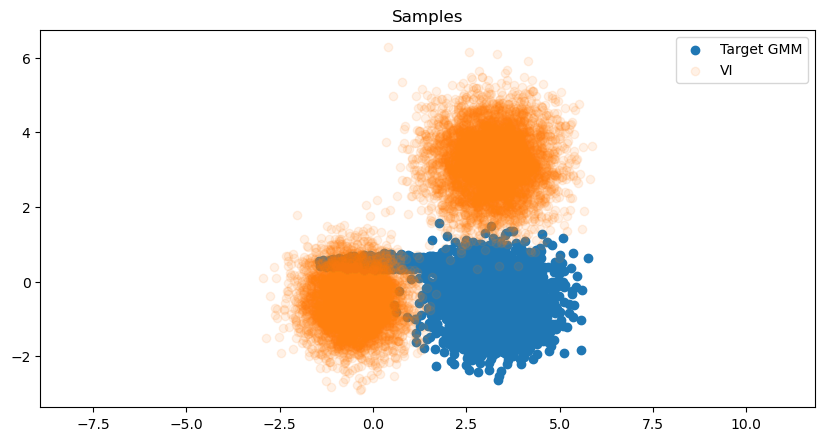

In [377]:
N = 5000

dist = torch.distributions.Bernoulli(probs=torch.sigmoid(pi_raw))
c = dist.sample((5000,1,1))
c = torch.cat((c,c), dim=1)
c = torch.cat((c,c), dim=2) # to same dim as u
 
u = std_normal.sample((N,2))

with torch.no_grad():
    std = torch.exp(stds_param_raw)
    sample_varfamily = c * (mus_param[0] + u * std[0]) + (1-c) * (mus_param[1] + u * std[1])
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI', alpha=0.1)
plt.axis('equal')
plt.legend();